In [1]:
from __future__ import division
import h5py
import pylab as plt
import numpy as np
import swordfish as sf
from tqdm import tqdm
from sklearn.linear_model import Ridge
from sklearn.neighbors import BallTree
from sklearn import svm
from WIMpy import DMUtils as DMU
from scipy.linalg import eig, eigvals
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})

In [11]:
def get_colors():
    # Colors for A, B, C, A and B
    colors = ['b', 'goldenrod', '#A0AAB2']
    return colors

def spline():
    x = np.linspace(2, 25, 100)
    y = np.sin(x)
    y = np.where(y>0, y, 0)

    f = interp1d(x[y>0], y[y>0], bounds_error = False, kind = 'quadratic',
            fill_value = 'extrapolate')
    plt.plot(x, f(x))
    plt.scatter(x, y)
    plt.show()

def make_plot(data, gap_rate = 0.5, label="test", operators=True, Ar=True):
    plt.figure(figsize = (4, 3))
    colors = get_colors()
    x_A = []
    x_B = []
    x_C = []
    y = []
    gap = 0
    for row in data:
        y0, y1, A, B, C, AandB = row
        dy = y1 - y0
        if AandB < 0.1:
            gap += gap_rate
            max_gap = C - B - A + AandB
            AandB = -min(gap, max_gap)
        AorB = A + B - AandB

        x0_C, x1_C = -0.5*C/dy, +0.5*C/dy
        x0_A, x1_B = -0.5*AorB/dy, +0.5*AorB/dy
        x1_A = x0_A + A/dy
        x0_B = x1_B - B/dy

        y.append([y0, y1])
        x_A.append([x0_A, x1_A])
        x_B.append([x0_B, x1_B])
        x_C.append([x0_C, x1_C])

    y = np.array(y)
    x_A = np.array(x_A)
    x_B = np.array(x_B)
    x_C = np.array(x_C)

    if operators:
        l_A = r'$\mathcal{H}_0:$ only $\mathcal{O}_{1}$'
        l_B = r'$\mathcal{H}_0:$ only $\mathcal{O}_{11}$'
        l_C = r'$\mathcal{H}_A:$ mixed $\mathcal{O}_1, \mathcal{O}_{11}$'
    else:
        l_A = r'$\mathcal{H}_0:$ only $\mathrm{Millicharge}$'
        l_B = r'$\mathcal{H}_0:$ only $\mathrm{Magnetic \, Dipole}$'
        l_C = r'$\mathcal{H}_A:$ mixed $\mathrm{Millicharge}, \mathrm{Magnetic Dipole}$'
        
    plt.fill_betweenx(y.mean(axis=1), x1 = x_C[:,0], x2 = x_C[:,1],
            color=colors[2], alpha = 0.5, linewidth = 0, label=l_C, hatch='')
    plt.fill_betweenx(y.mean(axis=1), x1 = x_A[:,0], x2 = x_A[:,1],
            color=colors[0], alpha = 0.5, linewidth = 0, label=l_A, hatch='|')
    plt.fill_betweenx(y.mean(axis=1), x1 = x_B[:,0], x2 = x_B[:,1],
            color=colors[1], alpha = 0.5, linewidth = 0, label=l_B, hatch='\\')
    plt.plot(x_B[:,0], y.mean(axis=1), linewidth = .5, color='k')
    plt.plot(x_B[:,1], y.mean(axis=1), linewidth = .5, color='k')
    plt.plot(x_A[:,0], y.mean(axis=1), linewidth = .5, color='k')
    plt.plot(x_A[:,1], y.mean(axis=1), linewidth = .5, color='k')
    plt.plot(x_C[:,0], y.mean(axis=1), linewidth = .5, color='0.5')
    plt.plot(x_C[:,1], y.mean(axis=1), linewidth = .5, color='0.5')
    #help(plt.fill_betweenx)

    Total = sum(data[:,4])
#     plt.text(-0.46, 7, str(int(Total)))
    if Ar:
        plt.title(r"XENONnT + DarkSide20k")
    else:
        plt.title(r"XENONnT")
    plt.ylabel("Number of signal events")
    plt.xlim(-2.,2.)
    plt.ylim(0,160)
    plt.gca().get_xaxis().set_visible(False)
    #plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().tick_params(axis='y', which='major', right='on')
    plt.legend(loc=4)
    plt.grid(linestyle='-', alpha = 0.3, zorder=-10000)
    plt.tight_layout(pad=0.3)
    plt.savefig("../plots/venn" + label + ".pdf")
    plt.show()

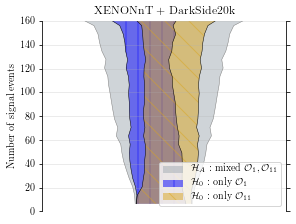

In [12]:
operator_Xe_Ar = np.loadtxt("venn_operators_Xe+Ar")
make_plot(operator_Xe_Ar, label="operator_Xe_Ar")

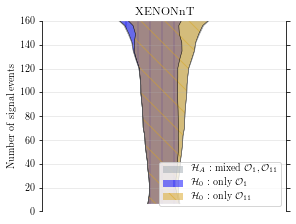

In [13]:
operator_Xe = np.loadtxt("venn_operators_Xe")
make_plot(operator_Xe, label="operator_Xe", Ar=False)

In [42]:
from scipy.interpolate import interp1d
from matplotlib_venn import venn3
from matplotlib.patches import Circle

def get_colors():
    # Colors for A, B, C, A and B
    colors = ['b', 'orange', '#A0AAB2']
    return colors

def make_plot_x(data, gap_rate = 0.5, label="test", Ar=True):
    plt.figure(figsize = (4, 3))
    colors = get_colors()
    x_A = []
    x_B = []
    x_C = []
    y = []
    gap = 0
    for row in data:
        y0, y1, A, B, C, AandB = row
        dy = y1 - y0
        AorB = A + B - AandB

        x0_C, x1_C = 0, C/dy
        x0_A, x1_B = 0, AorB/dy
        x1_A = A/dy
        x0_B = x1_B - B/dy

        y.append([y0, y1])
        x_A.append([x0_A, x1_A])
        x_B.append([x0_B, x1_B])
        x_C.append([x0_C, x1_C])

    y = np.array(y)
    x_A = np.array(x_A)
    x_B = np.array(x_B)
    x_C = np.array(x_C)

    l_A = r'$\mathcal{H}_0:$ only $\mathcal{O}_{1}$'
    l_B = r'$\mathcal{H}_0:$ only $\mathcal{O}_{11}$'
    l_C = r'$\mathcal{H}_A:$ mixed $\mathcal{O}_1, \mathcal{O}_{11}$'

    plt.fill_between(y.mean(axis=1), y1 = x_C[:,0], y2 = x_C[:,1],
            color=colors[2], alpha = 0.4, linewidth = 0, label=l_C)
    plt.fill_between(y.mean(axis=1), y1 = x_A[:,0], y2 = x_A[:,1],
            color=colors[0], alpha = 0.4, linewidth = 0, label=l_A)
    plt.fill_between(y.mean(axis=1), y1 = x_B[:,0], y2 = x_B[:,1],
            color=colors[1], alpha = 0.4, linewidth = 0, label=l_B)
    plt.fill_between(y.mean(axis=1), y1 = x_C[:,0], y2 = x_C[:,1],
            edgecolor = colors[2], facecolor = "none", linewidth = 0,
            hatch='--')
    plt.fill_between(y.mean(axis=1), y1 = x_A[:,0], y2 = x_A[:,1],
            edgecolor = colors[0], facecolor = "none", linewidth = 0,
            hatch='\\\\')
    plt.fill_between(y.mean(axis=1), y1 = x_B[:,0], y2 = x_B[:,1],
            edgecolor = colors[1], facecolor = "none", linewidth = 0,
            hatch='//')
    #help(plt.fill_betweenx)
    plt.plot(y.mean(axis=1), x_B[:,0], linewidth = 1, color=colors[1])
    plt.plot(y.mean(axis=1), x_B[:,1], linewidth = 1, color=colors[1])
    plt.plot(y.mean(axis=1), x_A[:,0], linewidth = 1, color=colors[0])
    plt.plot(y.mean(axis=1), x_A[:,1], linewidth = 1, color=colors[0])
    plt.plot(y.mean(axis=1), x_C[:,0], linewidth = 1, color=colors[2])
    plt.plot(y.mean(axis=1), x_C[:,1], linewidth = 1, color=colors[2])
    #help(plt.fill_betweenx)

    if Ar:
        plt.title(r"XENONnT + DarkSide20k")
    else:
        plt.title(r"XENONnT")
    plt.xlabel("Number of signal events, $N_S$")
    plt.ylabel("Number of distinct signals [A.U.]")
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.ylim([0, 3])
    plt.xlim([0, 160])
    plt.legend(loc=1, ncol=2)
    plt.tight_layout(pad=0.3)
    plt.savefig("../plots/venn_X"+label+".pdf")
    plt.show()

def make_plot_normal(data, gap_rate = 0.5, label="test", Ar=True):
    plt.figure(figsize = (4, 3))
    colors = get_colors()
    _, _, A, B, C, AandB = data.sum(axis=0)
    rC = (C/np.pi)**0.5
    rA, rB, dist = get_distance(A, B, AandB)
    if rA >= rB:
        dA = rC-rA
        dB = dA-dist
    else:
        dB = rC-rB
        dA = dB-dist

    l_A = r'$\mathcal{H}_0:$ only $\mathcal{O}_{1}$'
    l_B = r'$\mathcal{H}_0:$ only $\mathcal{O}_{11}$'
    l_C = r'$\mathcal{H}_A:$ mixed $\mathcal{O}_1, \mathcal{O}_{11}$'

    plt.fill_between([0,0], y1 = 0, y2 = 0, color=colors[2], alpha = 0.4,
            linewidth = 0, label=l_C)
    plt.fill_between([0,0], y1 = 0, y2 = 0, color=colors[0], alpha = 0.4,
            linewidth = 0, label=l_A)
    plt.fill_between([0,0], y1 = 0, y2 = 0, color=colors[1], alpha = 0.4,
            linewidth = 0, label=l_B)

    plt.gca().add_patch(Circle((0.0, 0.0), rC, fill = True, color=colors[2],
        alpha = 0.4))
    plt.gca().add_patch(Circle((dA, 0.0), rA, fill = True, color=colors[0],
            alpha = 0.4))
    plt.gca().add_patch(Circle((dB, 0.0), rB, fill = True, color=colors[1],
        alpha = 0.4))
    plt.gca().add_patch(Circle((0.0, 0.0), rC, fill = False, color=colors[2],
        hatch='--'))
    plt.gca().add_patch(Circle((dA, 0.0), rA, fill = False, color=colors[0],
        hatch='\\\\'))
    plt.gca().add_patch(Circle((dB, 0.0), rB, fill = False, color=colors[1],
        hatch='//'))

    if Ar:
        plt.title(r"XENONnT + DarkSide20k")
    else:
        plt.title(r"XENONnT")
    plt.xlim([-rC*1.3, rC*1.3])
    plt.ylim([-rC, rC])
    plt.legend(loc=1, ncol=2)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.ylim([-13, 20])
    plt.tight_layout(pad=0.3)
    plt.savefig("../plots/venn_N"+label+".pdf")
    plt.show()

def get_overlap(r1, r2, d):
    """Calculates overlap of two circles with radii r1 and r2, and central
    distance d."""
    if d > r1+r2:
        return 0.
    if d < abs(r1-r2):
        return min(r1,r2)**2*np.pi
    dth = np.sqrt(max(r1, r2)**2 - min(r1, r2)**2)
    y = (-d**4+2*d**2*r1**2+2*d**2*r2**2-
            r1**4+2*r1**2*r2**2-r2**4)**0.5/2/d
    x1 = np.sqrt(r1**2 - y**2)
    x2 = np.sqrt(r2**2 - y**2)
    O1 = (y*(r1**2-y**2)**0.5+r1**2*np.arctan(y/(r1**2-y**2)**0.5)
            -x1*y*2)
    O2 = (y*(r2**2-y**2)**0.5+r2**2*np.arctan(y/(r2**2-y**2)**0.5)
            -x2*y*2)
    if d > dth:
        O = O1 + O2
    else:
        if r1 > r2:
            O0 = r2**2*np.pi 
            O = O0+O1-O2
        else:
            O0 = r1**2*np.pi 
            O = O0+O2-O1
    return O

def get_distance(A, B, AandB):
    r1 = (A/np.pi)**0.5
    r2 = (B/np.pi)**0.5
    if AandB == 0.:
        return r1+r2
    if AandB == min(A, B):
        return abs(r1-r2)
    dgrid = np.linspace(abs(r1-r2), r1+r2, 100)
    AandBgrid = np.array([get_overlap(r1, r2, d) for d in dgrid])
    d = np.interp(AandB, AandBgrid[::-1], dgrid[::-1])
    return r1, r2, d

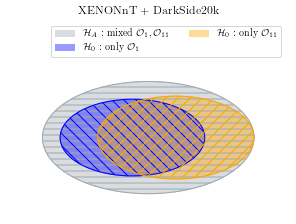

In [43]:
operator_Xe_Ar = np.loadtxt("venn_operators_Xe+Ar")
make_plot_normal(operator_Xe_Ar, label="operator_Xe_Ar")

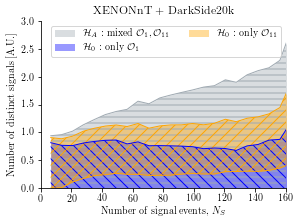

In [44]:
make_plot_x(operator_Xe_Ar, label="operator_Xe_Ar")

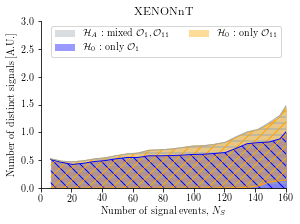

In [45]:
make_plot_x(operator_Xe, label="operator_Xe", Ar=False)